## Analysis of historical data of IPC levels
For this analysis we use two sources of IPC levels, those produced by FewsNet (https://fews.net) and those producted by Global IPC (http://www.ipcinfo.org).   
FewsNet has produced these analyses since 2009. Global IPC is a more recent initiative where the timing and coverage of the analysis depends on the country. For Ethiopia currently (Oct 2020) two analyses have been done, one in 2019 and one in 2020. 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.dates as dates
from sklearn.metrics import accuracy_score
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [2]:
country="ethiopia"
#suffix of filenames
suffix="_shape"

#### Load FewsNet data

In [3]:
df_fadm=pd.read_csv(f"Data/FewsNetProcessed/{country}_fewsnet_admin1{suffix}.csv",index_col=0)
df_fadm.date=pd.to_datetime(df_fadm.date)

In [4]:
def add_columns(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    # calculate percentage of population per analysis period and level
    for period in ["CS", "ML1", "ML2"]:
        # IPC level goes up to 5, so define range up to 6
        for i in range(1, 6):
            c = f"{period}_{i}"
            df[f"perc_{c}"] = df[c] / df[f"pop_{period}"] * 100
        # get pop and perc in IPC3+ and IPC2-
        # 3p = IPC level 3 or higher, 2m = IPC level 2 or lower
        df[f"{period}_3p"] = df[[f"{period}_{i}" for i in range(3, 6)]].sum(axis=1)
        df[f"perc_{period}_3p"] = df[f"{period}_3p"] / df[f"pop_{period}"] * 100
        df[f"{period}_2m"] = df[[f"{period}_{i}" for i in range(1, 3)]].sum(axis=1)
        df[f"perc_{period}_2m"] = df[f"{period}_2m"] / df[f"pop_{period}"] * 100
    df["perc_inc_ML2_3p"] = df["perc_ML2_3p"] - df["perc_CS_3p"]
    df["perc_inc_ML1_3p"] = df["perc_ML1_3p"] - df["perc_CS_3p"]
    return df

In [5]:
df_fadm=add_columns(df_fadm)

In [6]:
#group to country
df_fnat=df_fadm.groupby("date",as_index=False).sum()
#to make the plotting code work
df_fnat["ADM1_EN"]=country.capitalize()
df_fnat=add_columns(df_fnat)

##### Check for missing data

In [7]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_fadm[df_fadm.adjusted_population==0]))

Number of date-admin1 combinations with no IPC CS data: 0


In [8]:
print("Percentage of missing data:",len(df_fadm[df_fadm.adjusted_population==0])/len(df_fadm)*100)

Percentage of missing data: 0.0


#### Load Global IPC data

In [9]:
df_gadm=pd.read_csv(f"Data/GlobalIPCProcessed/{country}_globalipc_admin1{suffix}.csv",index_col=0)

In [10]:
glob_adm1c="ADMIN1"

In [11]:
df_gadm=add_columns(df_gadm)

In [12]:
#group to country
df_gnat=df_gadm.groupby("date",as_index=False).sum()
#to make the plotting code work
df_gnat[glob_adm1c]=country.capitalize()
df_gnat=add_columns(df_gnat)

### Analysis of historical IPC values
To get a better understanding of the country's typical values and history, both on national and admin1 level

In [13]:
def plot_ipclevels(df,adm1c="ADM1_EN",pop_col="adjusted_population",status="CS",figsize=(30,30),width=75):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
#     width = 75
    count = 1
    fig, ax = plt.subplots(figsize=figsize)
    if f"{status}_12" not in df.columns:
        df[f"{status}_12"]=df[f"{status}_1"]+df[f"{status}_2"]
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        df_c=df.copy()
        data = df_c.loc[df_c[adm1c]==region,:]

        p4 = plt.bar(data['date'], data[f'{status}_5'], width=width, color=color_map[5],label="IPC 5")
        p4 = plt.bar(data['date'], data[f'{status}_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data[f'{status}_3'], width=width, color=color_map[3], bottom=(data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data[f'{status}_12'], width=width, color=color_map[1], bottom=(data[f'{status}_3']+data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="IPC 1 and 2")
        data["pop_miss"]=data[pop_col]-(data[f"pop_{status}"].replace(np.nan,0))
        p1 = plt.bar(data['date'], data['pop_miss'], width=width, color=color_map[99], bottom=(data[f"{status}_12"]+data[f'{status}_3']+data[f'{status}_4']+data[f'{status}_5']).to_numpy(),label="Missing data")

        plt.title(f"{region} {status}")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Population")
        
        ax.xaxis.set_minor_locator(dates.MonthLocator())
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y'))
        plt.tight_layout()
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

#### FewsNet

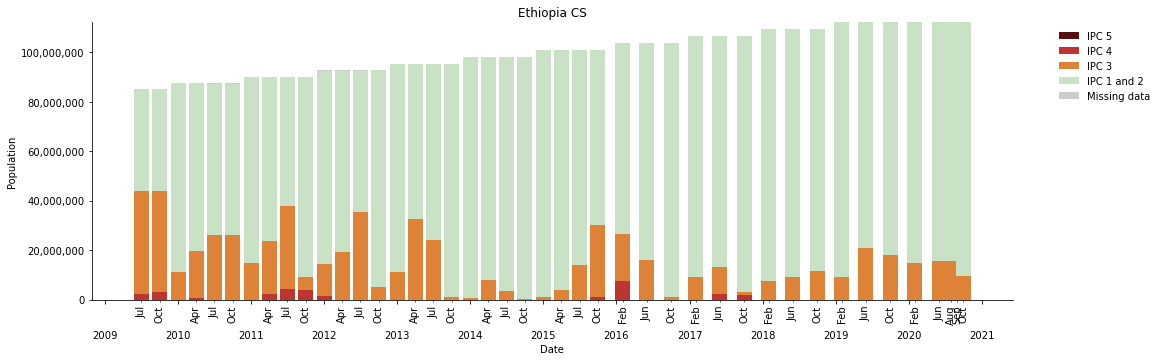

In [14]:
plot_ipclevels(df_fnat)

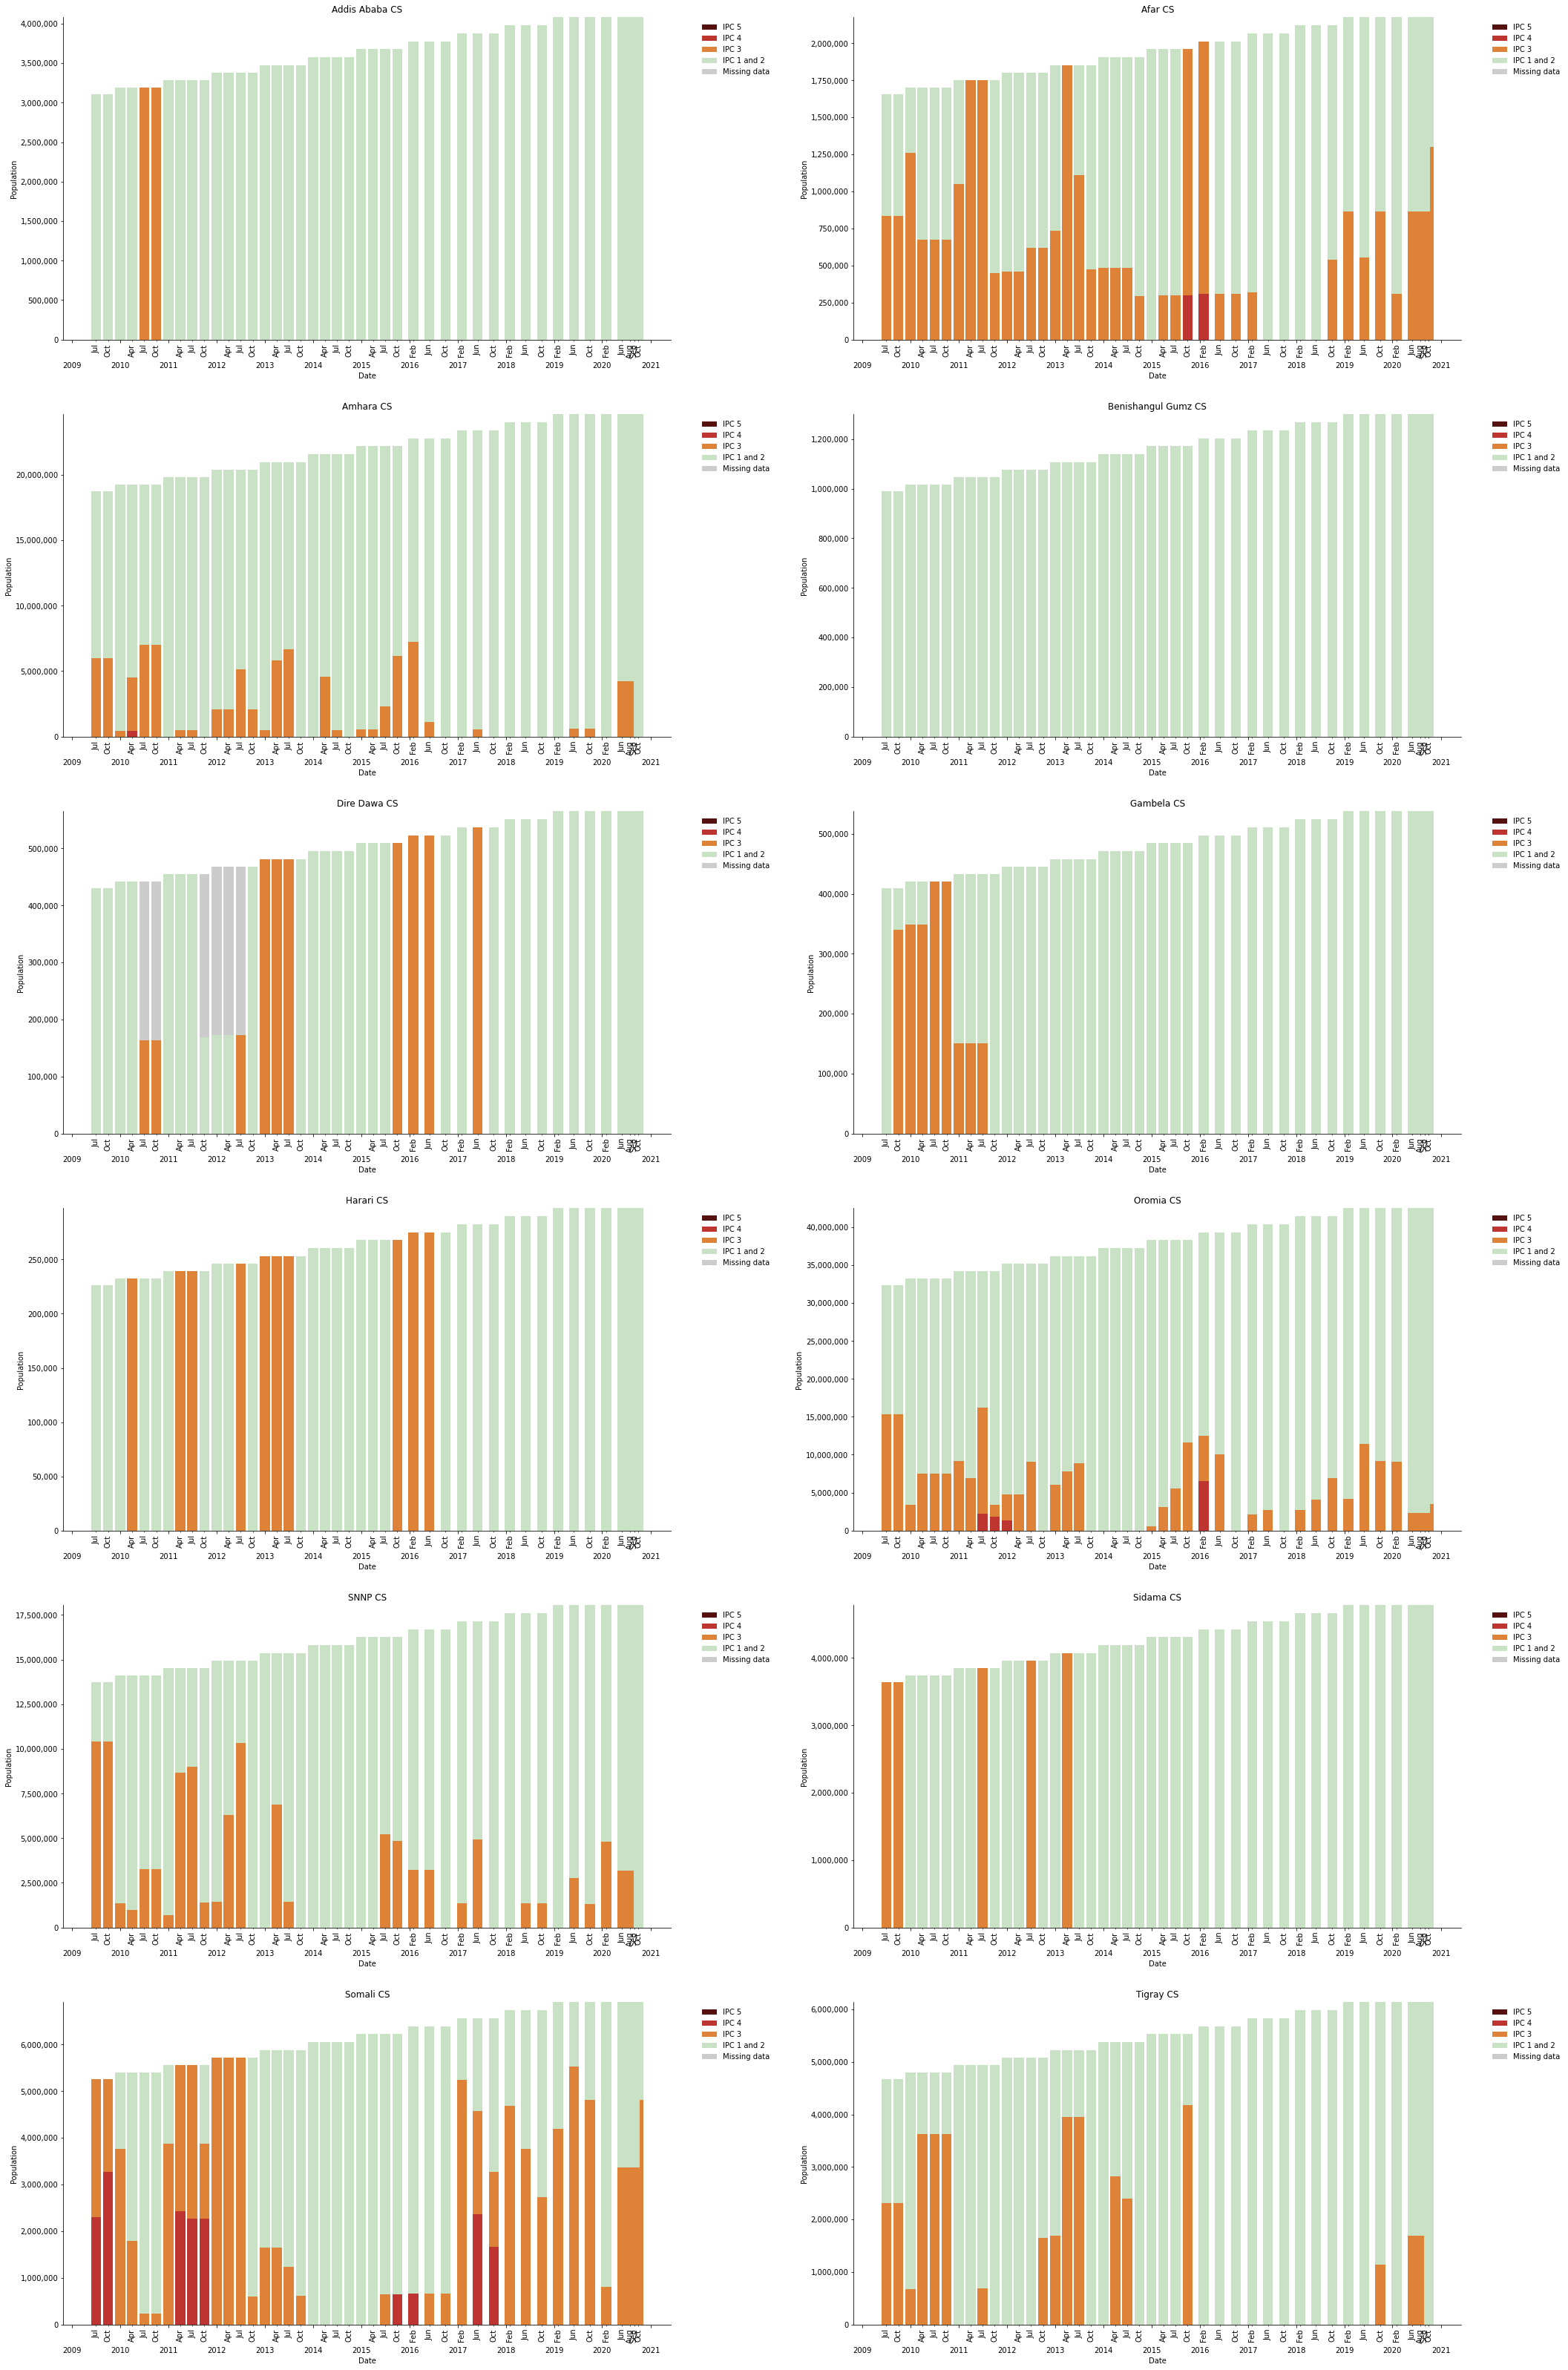

In [15]:
plot_ipclevels(df_fadm,figsize=(30,45))

#### Global IPC

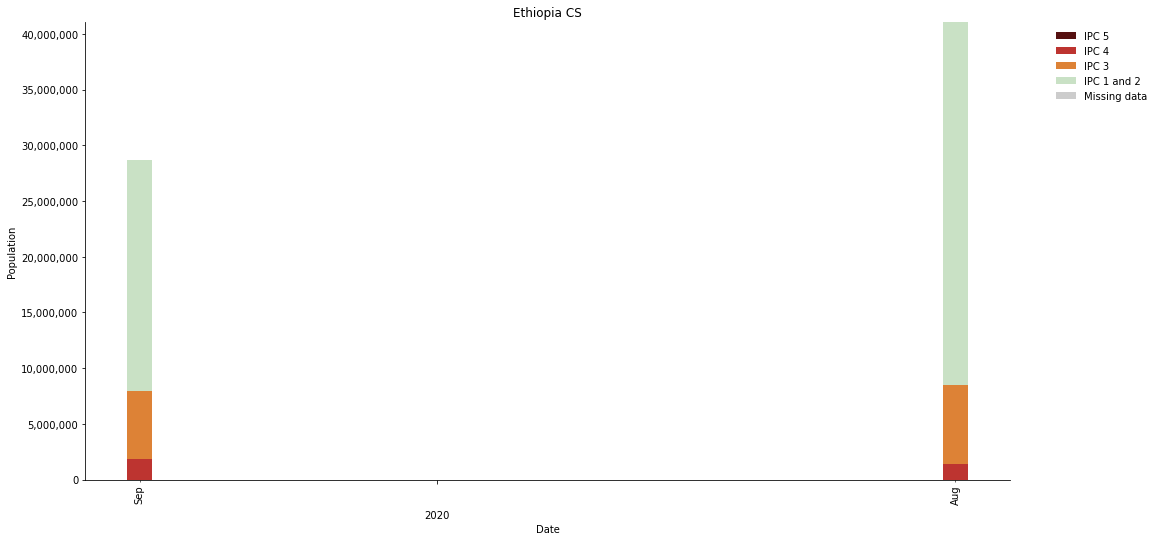

In [16]:
plot_ipclevels(df_gnat,adm1c=glob_adm1c,pop_col="pop_CS",figsize=(30,45),width=10)

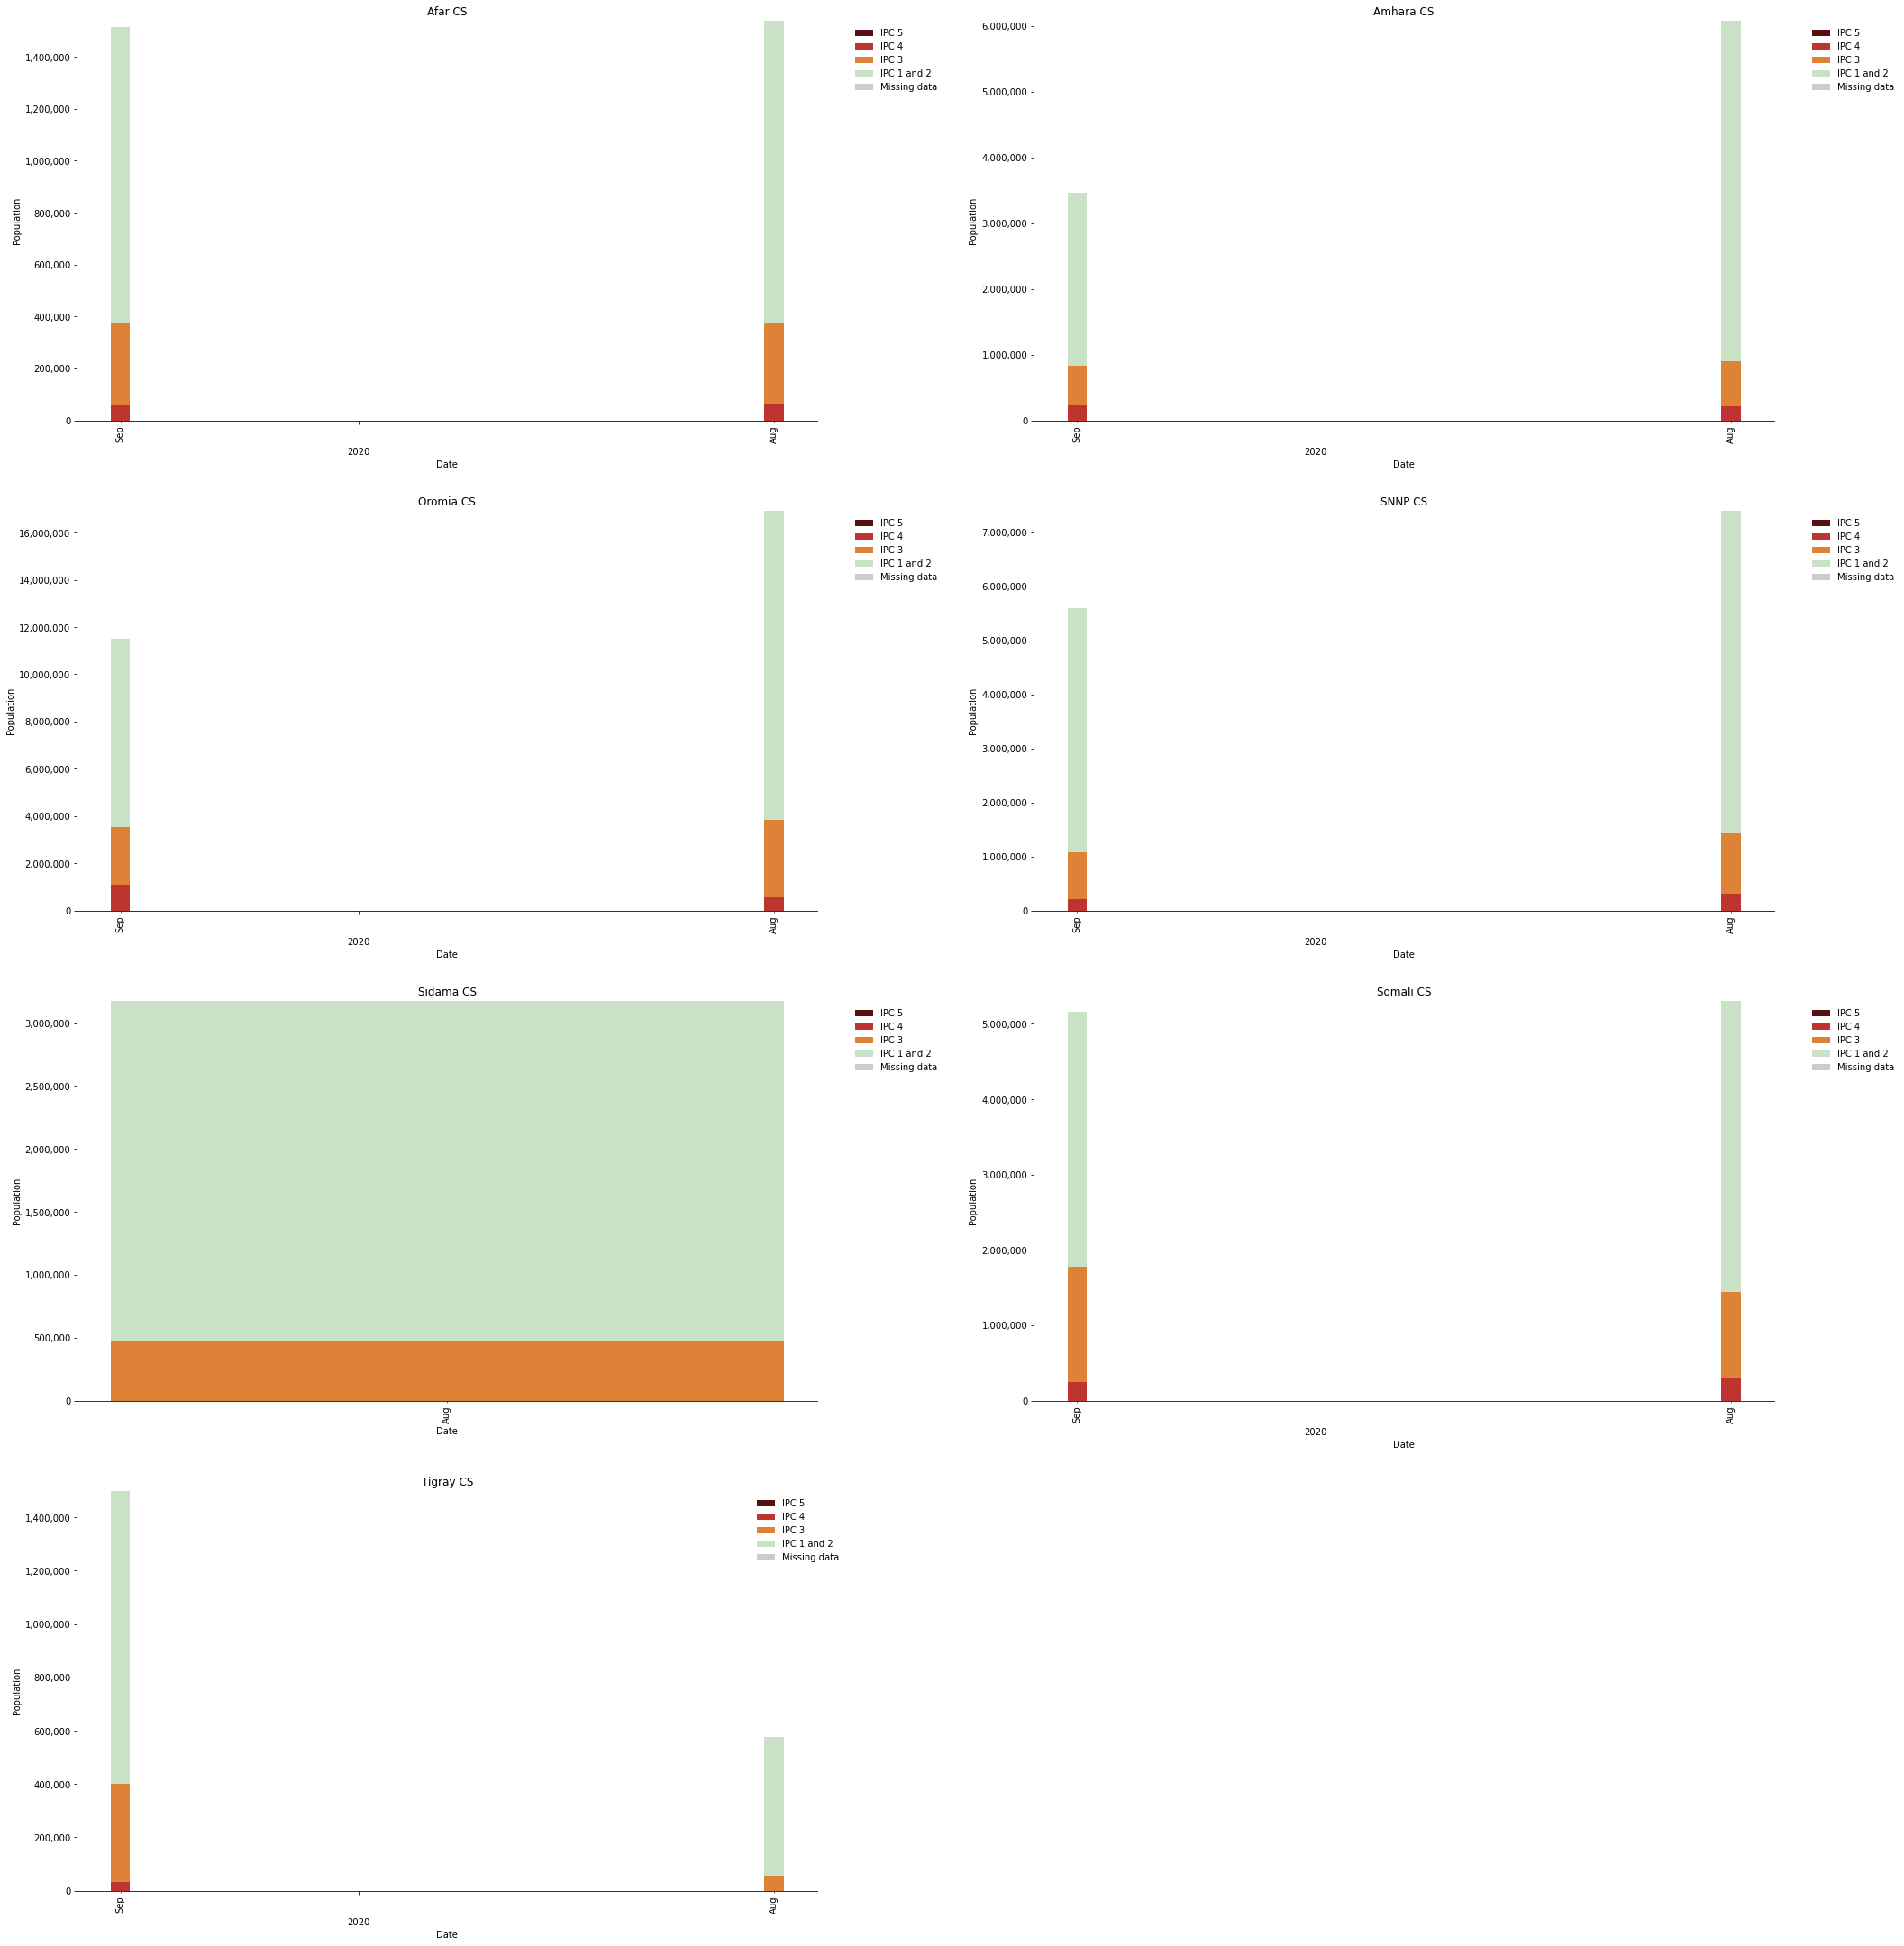

In [17]:
plot_ipclevels(df_gadm,adm1c=glob_adm1c,pop_col="pop_CS",figsize=(30,45),width=10)

In [18]:
def plot_aff_dates(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    """Plot a map with the values of col per admin1 for all dates included in df_d"""
    num_dates=len(df_d.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_d.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

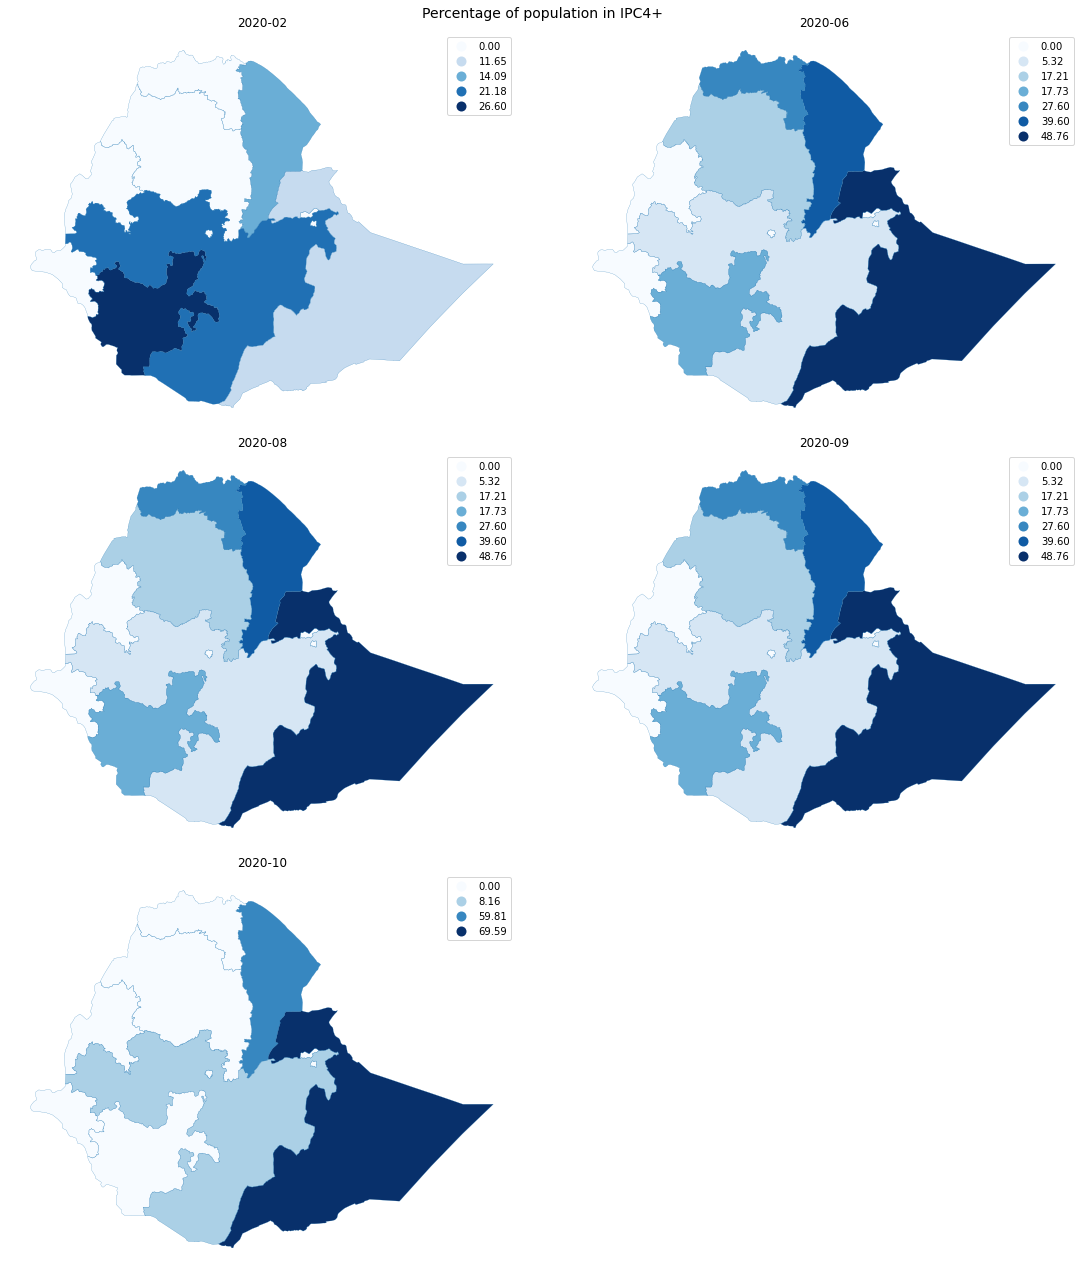

In [19]:
plot_aff_dates(df_fadm[df_fadm.date.dt.year==2020],"perc_CS_3p",title="Percentage of population in IPC4+")

### Compare Global IPC and FewsNet

In [20]:
df_fnat["Source"]="FewsNet"
df_gnat["Source"]="Global"

In [21]:
df_gnat.columns

Index(['date', 'CS_1', 'CS_2', 'CS_3', 'CS_4', 'CS_5', 'ML1_1', 'ML1_2',
       'ML1_3', 'ML1_4', 'ML1_5', 'ML2_1', 'ML2_2', 'ML2_3', 'ML2_4', 'ML2_5',
       'pop_CS', 'pop_ML1', 'pop_ML2', 'pop_ADMIN1', 'year', 'month',
       'perc_CS_1', 'perc_CS_2', 'perc_CS_3', 'perc_CS_4', 'perc_CS_5',
       'CS_3p', 'perc_CS_3p', 'CS_2m', 'perc_CS_2m', 'perc_ML1_1',
       'perc_ML1_2', 'perc_ML1_3', 'perc_ML1_4', 'perc_ML1_5', 'ML1_3p',
       'perc_ML1_3p', 'ML1_2m', 'perc_ML1_2m', 'perc_ML2_1', 'perc_ML2_2',
       'perc_ML2_3', 'perc_ML2_4', 'perc_ML2_5', 'ML2_3p', 'perc_ML2_3p',
       'ML2_2m', 'perc_ML2_2m', 'perc_inc_ML2_3p', 'perc_inc_ML1_3p', 'ADMIN1',
       'CS_12', 'Source'],
      dtype='object')

In [22]:
col_list=["Source","pop_Country","date","pop_CS","pop_ML1","pop_ML2"]+[f"CS_{i}" for i in range(1,6)]+[f"ML1_{i}" for i in range(1,6)]+[f"ML2_{i}" for i in range(1,6)]+[f"perc_CS_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]
df_fnat=df_fnat.rename(columns={"adjusted_population":"pop_Country"})
df_gnat=df_gnat.rename(columns={"pop_ADMIN1":"pop_Country"})
df_fnats=df_fnat[col_list]
df_gnats=df_gnat[col_list]

In [23]:
#manually select the closes dates of Global IPC and FewsNet..
list(df_gnats.date.dt.date.unique())

[datetime.date(2019, 9, 1), datetime.date(2020, 8, 1)]

In [24]:
df_fnats.date.dt.date.unique()

array([datetime.date(2009, 7, 1), datetime.date(2009, 10, 1),
       datetime.date(2010, 1, 1), datetime.date(2010, 4, 1),
       datetime.date(2010, 7, 1), datetime.date(2010, 10, 1),
       datetime.date(2011, 1, 1), datetime.date(2011, 4, 1),
       datetime.date(2011, 7, 1), datetime.date(2011, 10, 1),
       datetime.date(2012, 1, 1), datetime.date(2012, 4, 1),
       datetime.date(2012, 7, 1), datetime.date(2012, 10, 1),
       datetime.date(2013, 1, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 10, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 10, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 4, 1),
       datetime.date(2015, 7, 1), datetime.date(2015, 10, 1),
       datetime.date(2016, 2, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 10, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 6, 1), datetime.date(2017, 10, 1),
       datetime

In [25]:
df_fnatsd=df_fnats[df_fnats.date.isin(["2019-10","2020-10"])]

In [26]:
df_comb=pd.concat([df_gnats,df_fnatsd])

In [27]:
df_comb

Source  pop_Country       date       pop_CS      pop_ML1      pop_ML2  \
0    Global          0.0 2019-09-01   28727077.0   28727077.0   29224402.0   
1    Global          0.0 2020-08-01   41028219.0   41028219.0   41808767.0   
37  FewsNet  112078683.0 2019-10-01  112078683.0  112078683.0  112078683.0   
42  FewsNet  112078683.0 2020-10-01  112078683.0  112078683.0  112078683.0   

          CS_1        CS_2        CS_3       CS_4  ...  perc_ML1_1  \
0   10726485.0  10033537.0   6110375.0  1856531.0  ...   40.005591   
1   19514840.0  13007693.0   7064142.0  1441541.0  ...   53.419652   
37  63431293.0  30791647.0  17855743.0        0.0  ...   71.981917   
42  69393297.0  33101776.0   9583610.0        0.0  ...   59.518692   

    perc_ML1_2  perc_ML1_3  perc_ML1_4  perc_ML1_5  perc_ML2_1  perc_ML2_2  \
0    36.706798   18.644267    4.642881         0.0   35.773981   35.230179   
1    30.322486   14.273240    1.984627         0.0   42.938346   30.552503   
37   18.711944    9.306139    0.000000         0.0   56.189001   26.371071   
42   23.488557   16.992751    0.000000         0.0   42.418380   26.739565   

    perc_ML2_3  perc_ML2_4  perc_ML2_5  
0    22.231572    6.763820         0.0  
1    21.424918    5.084252         0.0  
37   17.439928    0.000000         0.0  
42   30.842055    0.000000         0.0  

[4 rows x 36 columns]

In [28]:
df_comb.columns

Index(['Source', 'pop_Country', 'date', 'pop_CS', 'pop_ML1', 'pop_ML2', 'CS_1',
       'CS_2', 'CS_3', 'CS_4', 'CS_5', 'ML1_1', 'ML1_2', 'ML1_3', 'ML1_4',
       'ML1_5', 'ML2_1', 'ML2_2', 'ML2_3', 'ML2_4', 'ML2_5', 'perc_CS_1',
       'perc_CS_2', 'perc_CS_3', 'perc_CS_4', 'perc_CS_5', 'perc_ML1_1',
       'perc_ML1_2', 'perc_ML1_3', 'perc_ML1_4', 'perc_ML1_5', 'perc_ML2_1',
       'perc_ML2_2', 'perc_ML2_3', 'perc_ML2_4', 'perc_ML2_5'],
      dtype='object')

In [29]:
df_comb=add_columns(df_comb)

In [30]:
df_combm=df_comb.melt(id_vars=["Source","date","year"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])

In [31]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800) #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_CS_2-","perc_CS_3","perc_CS_4","perc_CS_5"])
fig.show()

In [32]:
g_adm1=df_gadm.ADMIN1.unique()

In [33]:
df_fadms=df_fadm[df_fadm.date.isin(["2019-10","2020-06"])]

In [34]:
df_fadms=df_fadms.rename(columns={"ADM1_EN":"ADMIN1"})
df_fadms=df_fadms[df_fadms.ADMIN1.isin(g_adm1)]

df_fadms["Source"]="FewsNet"
df_gadm["Source"]="Global"

In [35]:
df_adm1c=pd.concat([df_gadm,df_fadms])


In [36]:
df_adm1cm=df_adm1c.melt(id_vars=["Source","date","ADMIN1"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])
df_adm1cm["year"]=df_adm1cm.date.dt.year

In [37]:
#Sidama is a new admin1 region in Ethiopia that wasn't included in the 06-2020 FewsNet analysis
px.bar(df_adm1cm[df_adm1cm.year==2020],x="variable",y="percentage",color="Source",facet_col="ADMIN1",barmode="group",height=400,width=1300) #,facet_row="year"

### Actual value (CS) versus forecasted values (ML1 and ML2)
Only being done for FewsNet.  
For global IPC we have two timestamps of data till today, where none of the dates overlap. Thus, we cannot do an analysis on accuracy

In [38]:
#set the forecasted ML1 and ML2 values for the connected date
#now assumed ML1 is always forecasted for the next date in the df. This can be too simplified, in 'old stuff' is a start to do this more correctly
#(optimally the dates for which forecasts were produced would already be included in the df from the start)
shift_cols_ML1=["date"] + [f"ML1_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+["ML1_3p","perc_ML1_3p"]
shift_cols_ML2=["date"] + [f"ML2_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]+["ML2_3p","perc_ML2_3p"]
df_fnat[[f"{c}_next" for c in shift_cols_ML1]]=df_fnat[shift_cols_ML1].shift(1)
df_fnat[[f"{c}_next2" for c in shift_cols_ML2]]=df_fnat[shift_cols_ML2].shift(2)
df_fadm[[f"{c}_next" for c in shift_cols_ML1]]=df_fadm.groupby("ADM1_EN")[shift_cols_ML1].shift(1)
df_fadm[[f"{c}_next2" for c in shift_cols_ML2]]=df_fadm.groupby("ADM1_EN")[shift_cols_ML2].shift(2)

#set to nan if difference in dates is larger than 130/250, i.e. forecast was not for next date in df
#dont include "date" in shift_cols_ML1
for i in shift_cols_ML1[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next) <= timedelta(130), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next) <= timedelta(130), np.nan)
for i in shift_cols_ML2[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next2) <= timedelta(250), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next2) <= timedelta(250), np.nan)

In [39]:
df_fadmt=pd.read_csv(f"Data/FewsNetProcessed/{country}_fewsnet_admin2{suffix}.csv",index_col=0)

In [40]:
#add forecasted values to date they were forecasted for
for a in df_fadmt.ADM1_EN.unique():
    for b in df_fadmt.ADM2_EN.unique():
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"ML1_next"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"ML1"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"ML2_next2"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"ML2"].shift(2).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"date_next"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"date"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),f"date_next2"]=df_fadmt.loc[(df_fadmt.ADM1_EN==a) & (df_fadmt.ADM2_EN==b),"date"].shift(2).to_numpy()

In [41]:
df_fadmt["CS_3p"]=np.where(df_fadmt.CS>=3,1,0)
df_fadmt["ML1_next_3p"]=np.where(df_fadmt.ML1_next>=3,1,0)
df_fadmt["ML2_next2_3p"]=np.where(df_fadmt.ML2_next2>=3,1,0)

In [42]:
df_fadmts=df_fadmt.dropna()

In [43]:
print("Accuracy of ML1 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML1_next))

Accuracy of ML1 forecasts: 0.7804942864735583


In [44]:
print("Accuracy of ML2 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML2_next2))

Accuracy of ML2 forecasts: 0.7222960403933032


In [45]:
print("Accuracy of ML1 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML1_next_3p))

Accuracy of ML1 forecasts for IPC3+: 0.8748339091150678


In [46]:
print("Accuracy of ML2 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML2_next2_3p))

Accuracy of ML2 forecasts for IPC3+: 0.8410842412968377


In [47]:
df_fadmt["CSminML1"]=df_fadmt["CS"]-df_fadmt["ML1_next"]

In [48]:
#can be seen that about equally divided whether ML1 is over or underpredicting CS
df_fadmt.value_counts("CSminML1").sort_index()

CSminML1
-3.0       1
-2.0      18
-1.0     407
 0.0    3030
 1.0     386
 2.0      15
dtype: int64

In [49]:
df_fadmt["CSminML2"]=df_fadmt["CS"]-df_fadmt["ML2_next2"]

In [50]:
df_fadmt.value_counts("CSminML2").sort_index()

CSminML2
-3.0       2
-2.0      46
-1.0     485
 0.0    2718
 1.0     469
 2.0      43
dtype: int64

In [51]:
px.scatter(df_fadm,x="perc_CS_3",y="perc_ML1_3_next",width=500,height=450)

In [52]:
def plot_preds(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p_next'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p_next2'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"{region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percentage of population")
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)

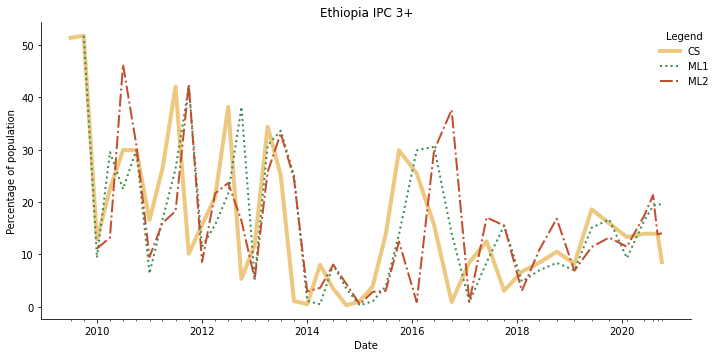

In [53]:
plot_preds(df_fnat)

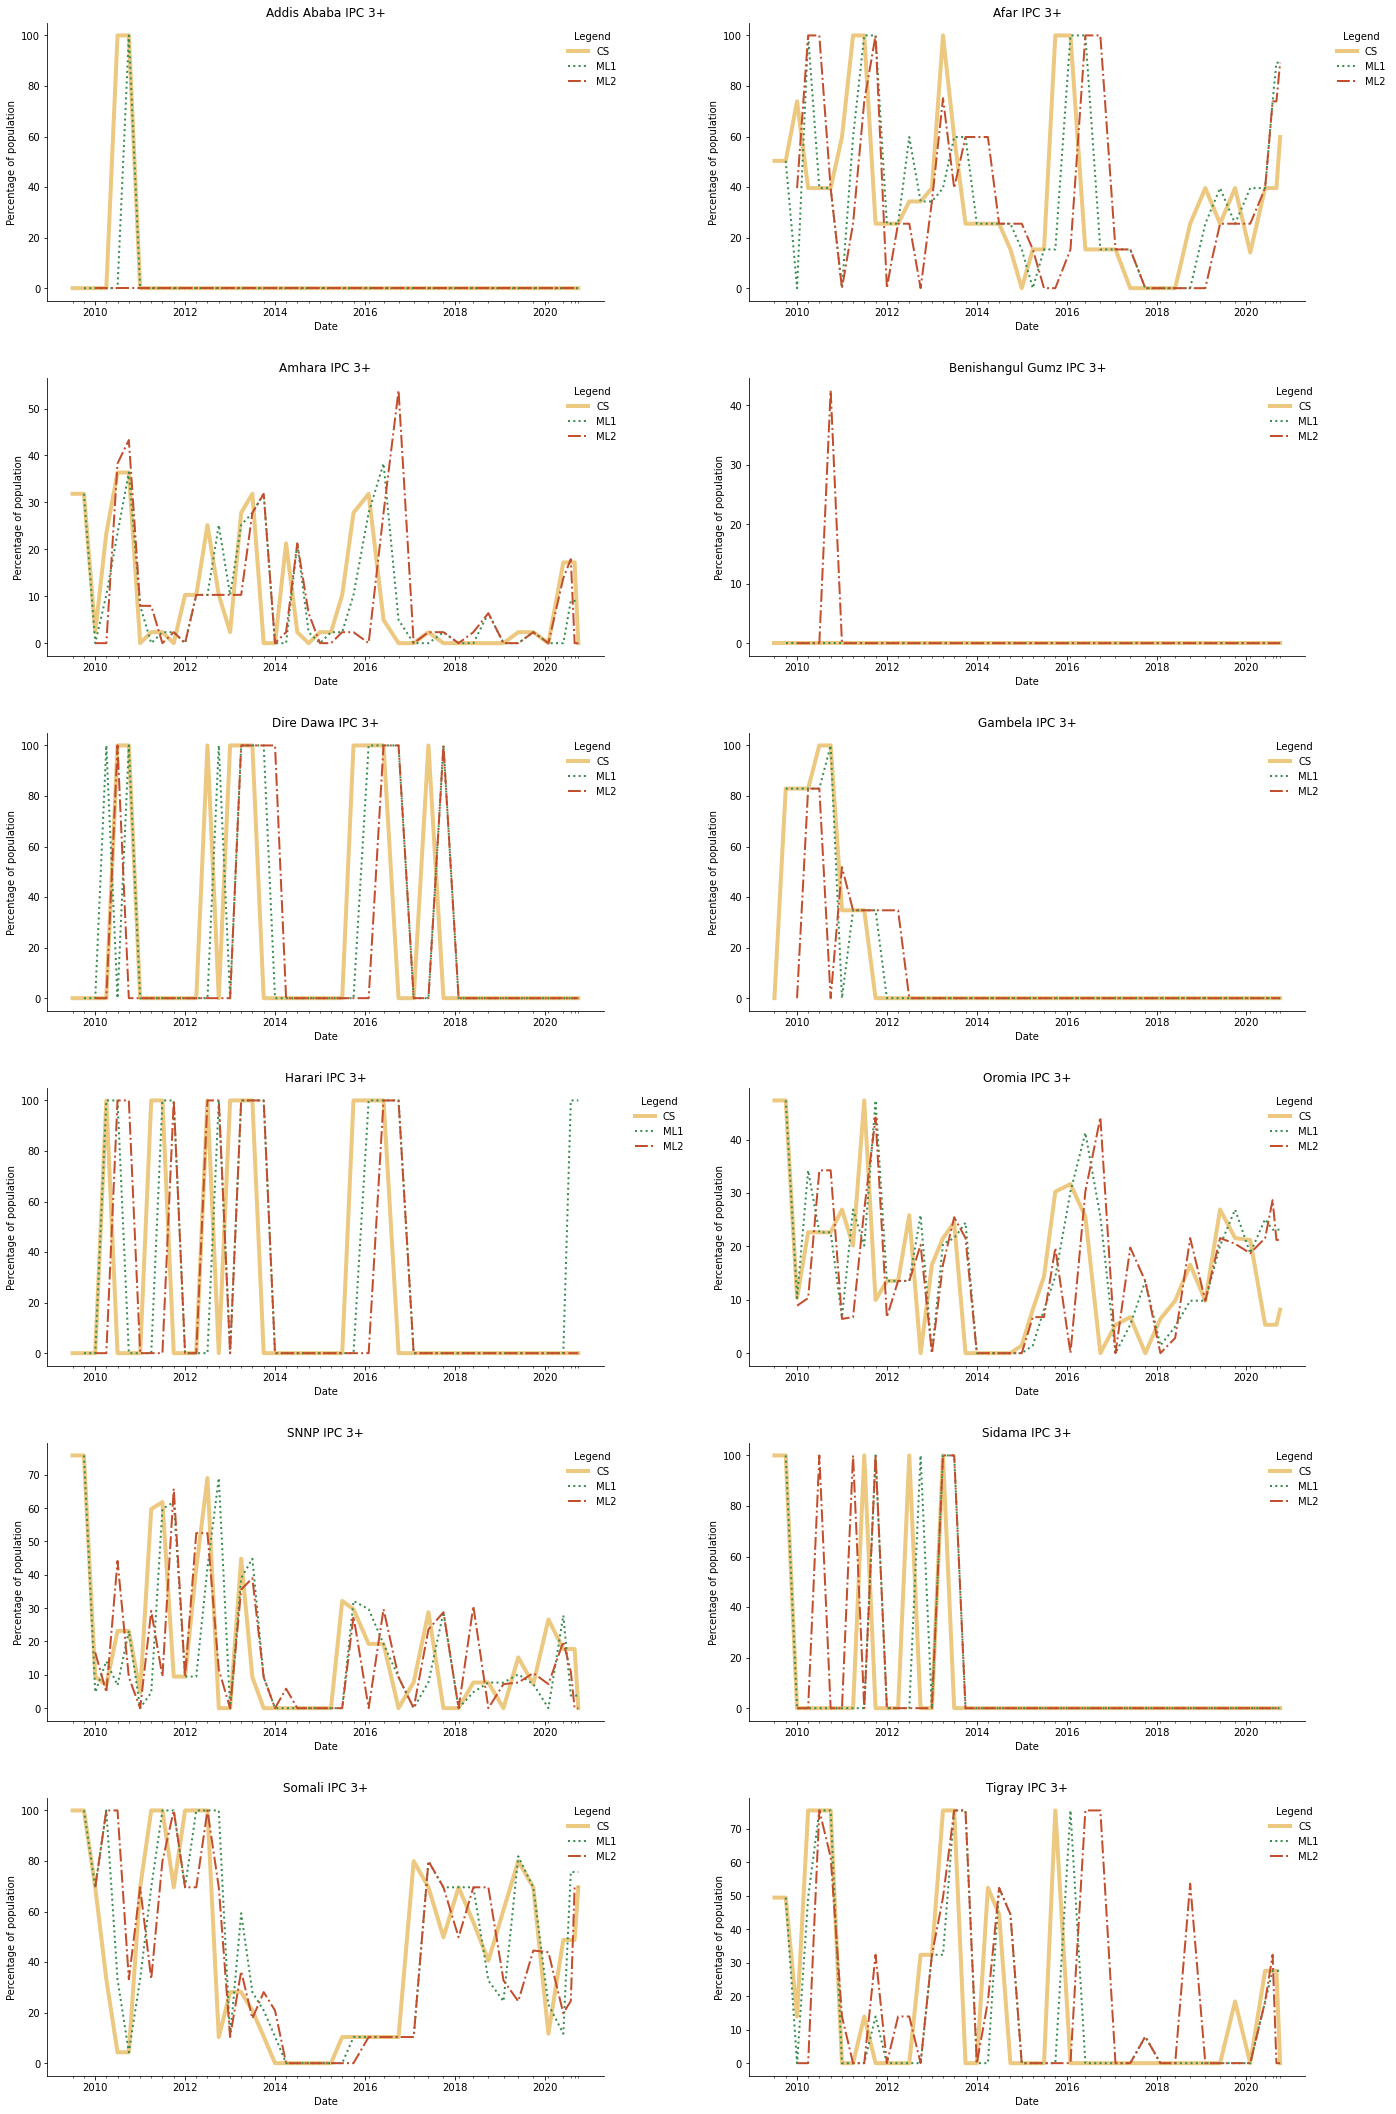

In [54]:
plot_preds(df_fadm)

In [55]:
def plot_preds_nodelay(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"NO DELAY! {region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

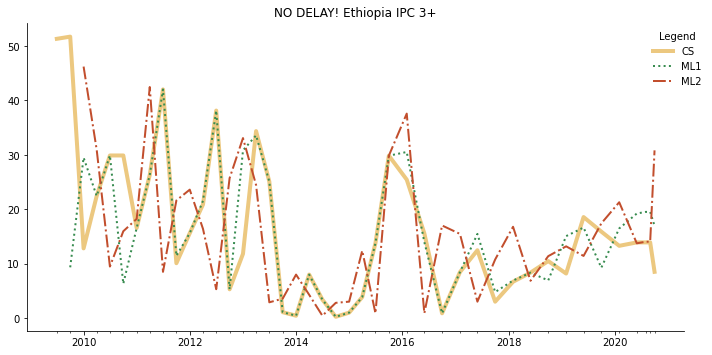

In [56]:
plot_preds_nodelay(df_fnat)

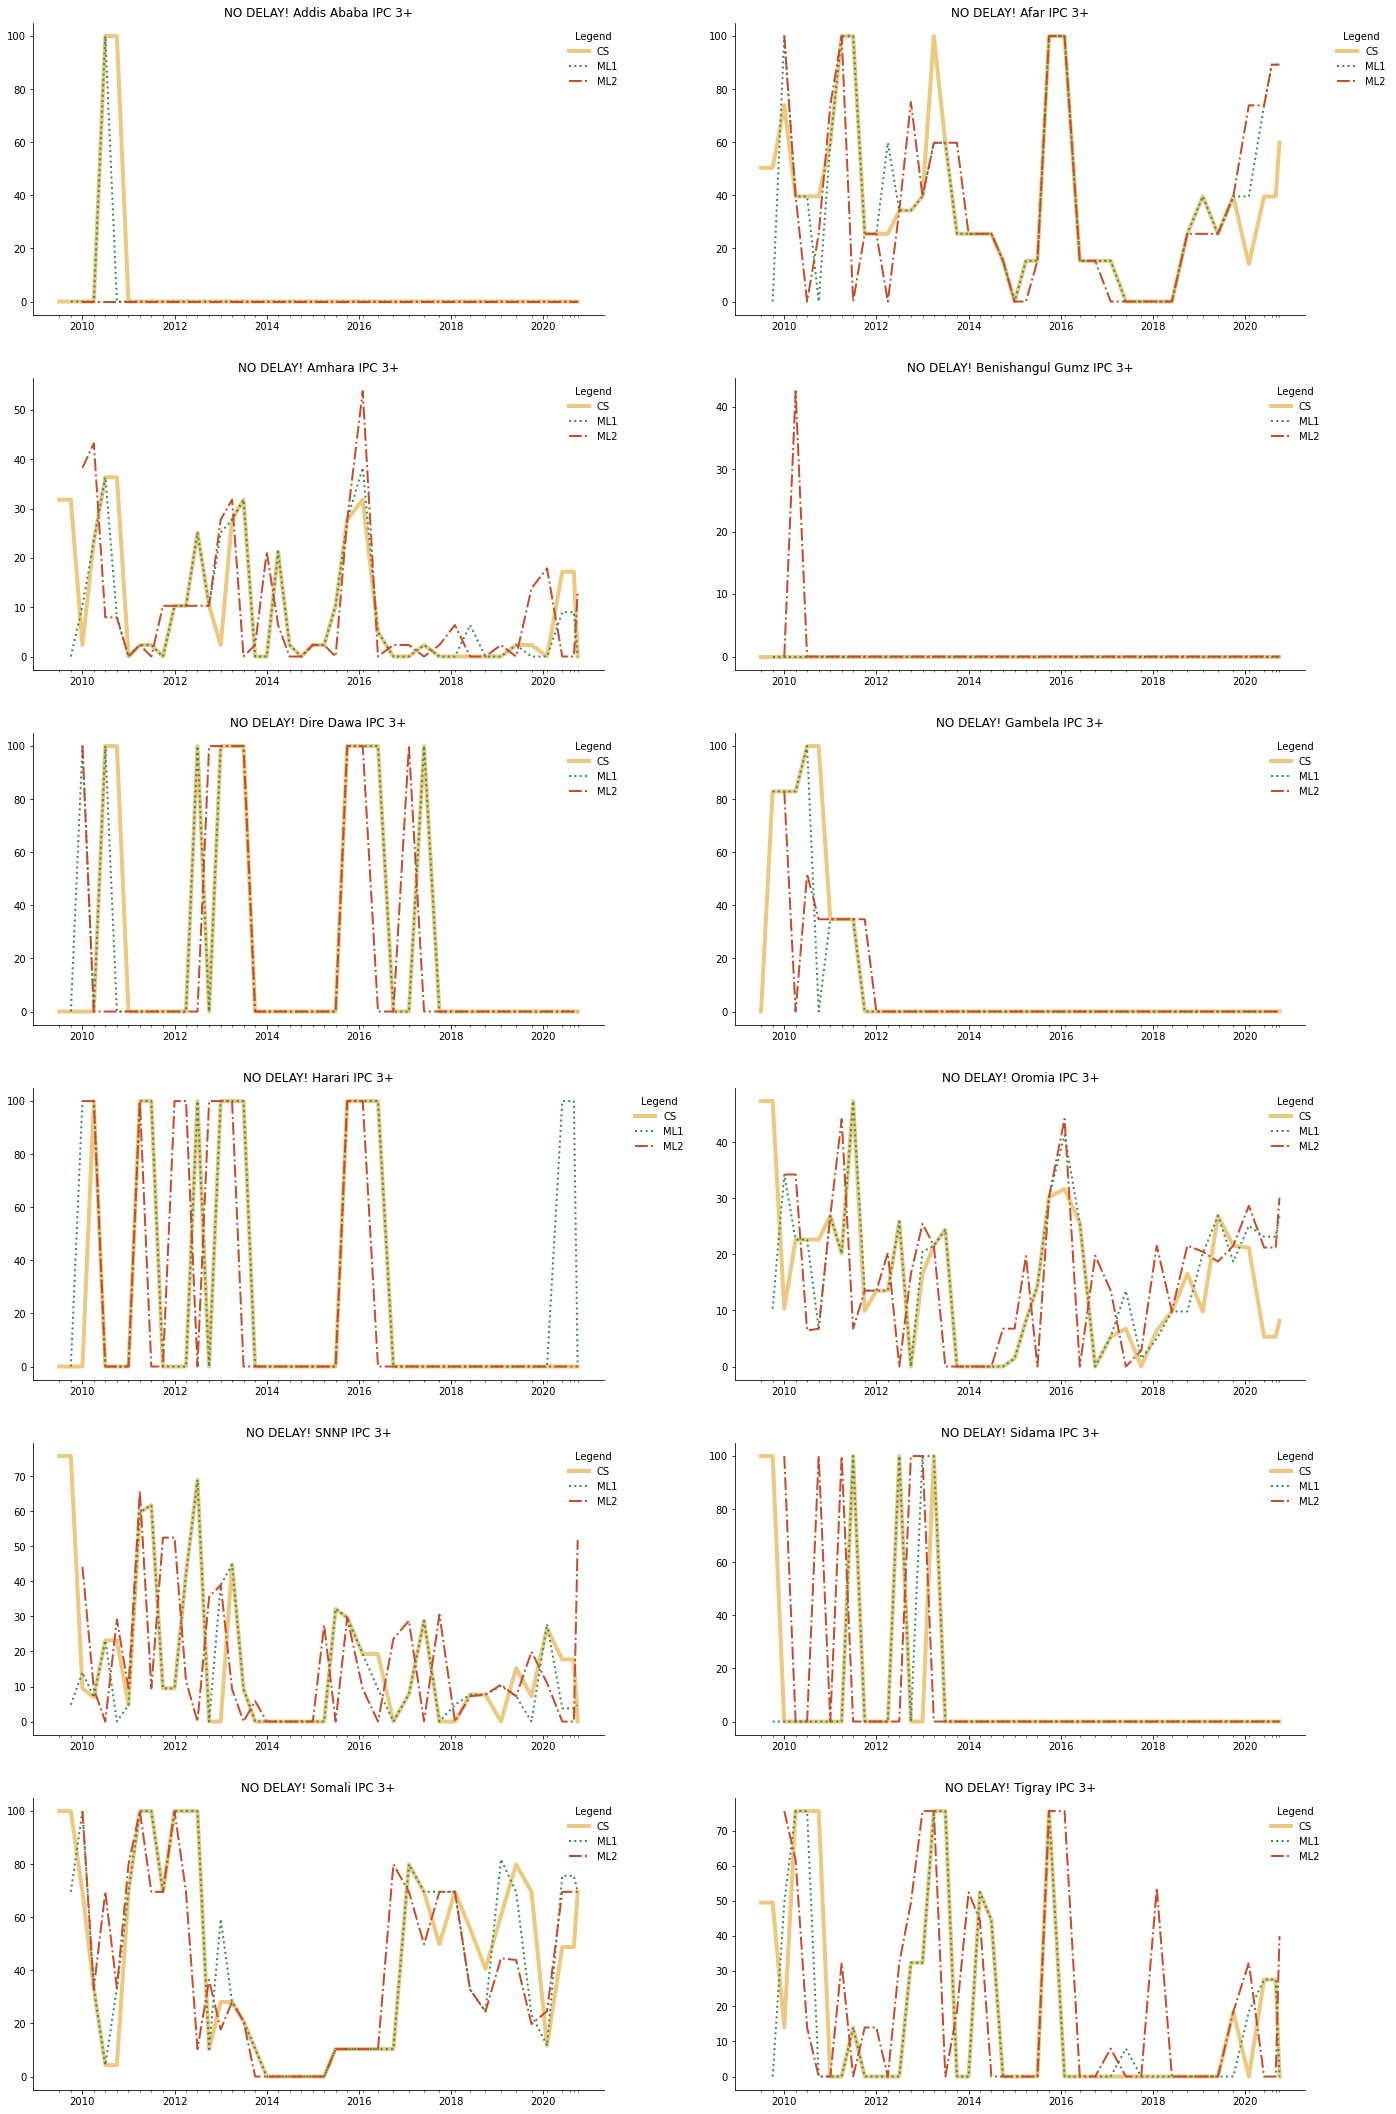

In [57]:
plot_preds_nodelay(df_fadm)

In [58]:
df_fnat[f"ML1_i"]=(df_fnat["perc_ML1_3p"]-df_fnat["perc_CS_3p"])
df_fnat[f"ML2_i"]=(df_fnat["perc_ML2_3p"]-df_fnat["perc_CS_3p"])

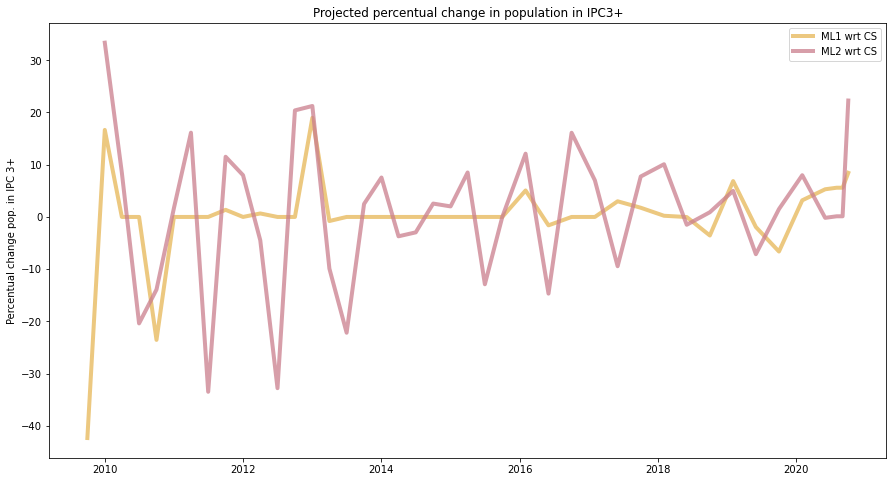

In [59]:
plt.figure(figsize=(15, 8))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(df_fnat['date'], df_fnat['ML1_i'], label='ML1 wrt CS',
                 alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
plt.plot(df_fnat['date'], df_fnat['ML2_i'], label='ML2 wrt CS',
                 alpha=0.75, color='#CA7E8D', linestyle='-', linewidth=4)
plt.ylabel("Percentual change pop. in IPC 3+")
plt.title("Projected percentual change in population in IPC3+")
plt.legend()